# Gerardo de Miguel González

# Pipeline Proof of Concept

## References

**::GMG::** I'm going to learn *how to automate workflows* in a machine learning project, keeping *good practices* and avoiding mistakes like [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/). The key is the use of the [`pipeline` module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) from scikit-learn. I've use the following references:

  - [Machine Learning Process](https://machinelearningmastery.com/an-introduction-to-feature-selection/) An Introduction to Feature Selection. By Jason Brownlee on October 6, 2014
  - [Python Machine Learning](https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/) Automate Machine Learning Workflows with Pipelines in Python and scikit-learn. By Jason Brownlee on June 6, 2016
  
**::NOTE::** There is an example from scikit-learn documentation that could also be used as a template, i.e. [Concatenating multiple feature extraction methods](https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html#sphx-glr-auto-examples-compose-plot-feature-union-py). The dataset used is not suited to the technique (I thin I can find a more suitable one ...) but *the workflow* is the important thing to keep here. The [*combination* of feature engineering techniques](https://scikit-learn.org/stable/modules/compose.html#feature-union) is also important in this case.

## Libraries

In [1]:
#::GMG::Basic Dataset Management: dataframes and ndarrays
import pandas as pd
import numpy as np

In [2]:
#::GMG::seaborn: statistical data visualization for a heatmap of pandas.corr()
#::NOTE::There's a lot of fuss for 'heatmapping' with matplotlib only
# https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
#::GMG::Data split and cross-validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate

In [4]:
#::GMG::Feature engineering pre-processing (feature extraction and selection)
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html
# https://scikit-learn.org/stable/modules/compose.html#feature-union
# https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

In [5]:
#::GMG::Model to train, test and evualate
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression

In [6]:
#::GMG::Pipeline, the star of this notebook :)
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline
from sklearn.pipeline import Pipeline

In [10]:
#::GMG::openml.org data repository access
# https://docs.openml.org/sklearn/
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html
#::NOTE::The API is experimental (particularly the return value structure), and might have 
#        small backward-incompatible changes in future releases.
from sklearn.datasets import fetch_openml

In [51]:
#::GMG::ROC/AUC
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

## Dataset

### load

**::GMG::** The dataset *was available* in [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) but there's only [a text file](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/) with a notice at the moment what reads:

*Thank you for your interest in the Pima Indians Diabetes dataset. 
The dataset is no longer available due to permission restrictions.*

**::GMG::** There's another version of the dataset that can be raw downloaded from the [dataset folder](https://github.com/jbrownlee/Datasets) in the [Github repository of Jason Brown Lee](https://github.com/jbrownlee) a known [data scientist blogger](https://machinelearningmastery.com/) ....

In [7]:
# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
pima = pd.read_csv(url, names=names)

In [8]:
pima.tail()

,preg,plas,pres,skin,test,mass,pedi,age,class
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [11]:
print("Diabetes data set dimensions: {}".format(pima.shape))

Diabetes data set dimensions: (768, 9)


**::GMG::** There are **8** different integer and real *features* and the categorical (binary) *class* (i.e. classification variable or predictor) where 1 stands for having diabetes (*positive*), and 0 denotes not having diabetes (*negative*). The dataset is known to have *missing values*. Specifically, there are missing observations for some columns that are marked as a zero value. A zero value will be a phisically impossible (*invalid*) value (*outlier*) for Plasma glucose concentration (`plas`), Diastolic blood pressure (`pres`), Triceps skin fold thickness (`skin`), 2-Hour serum insulin (`test`) and body mass index (`mass`). If I want to get rid of the ouliers by removing them or imputation I need to do some *pre-processing* tasks to be included within the pipeline.

**::NOTE::** There's a complete description of this dataset [in openml](https://www.openml.org/d/37). By the way, this dataset repository [may be used](https://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-openml-org-repository) using [scikit learn  dataset loading utilities](https://scikit-learn.org/stable/datasets/index.html), specifically `sklearn.datasets.fetch_openml` ([see doc](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html)).

In [17]:
#::GMG::Alternative download from openml
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html
#::NOTE::Here to the point: X = features, y = class
#        X, y = fetch_openml(name = 'diabetes', version=1, return_X_y=True)
#        BUT I'm going to do it different
# pima indians diaetes located in open ml utl: https://www.openml.org/d/37 (-> ID = 37)
#pima_2 = fetch_openml(data_id = 37)

**::NOTE::** I wasn't able to do this in Data Science Hub. It yielded an error:

```python
---------------------------------------------------------------------------
JSONDecodeError                           Traceback (most recent call last)
<ipython-input-16-9c4b80beb121> in <module>
      5 #        BUT I'm going to do it different
      6 # pima indians diaetes located in open ml utl: https://www.openml.org/d/37 (-> ID = 37)
----> 7 pima_2 = fetch_openml(data_id = 37)

[...]

/opt/conda/lib/python3.6/json/decoder.py in raw_decode(self, s, idx)
    355             obj, end = self.scan_once(s, idx)
    356         except StopIteration as err:
--> 357             raise JSONDecodeError("Expecting value", s, err.value) from None
    358         return obj, end

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

```

**::NOTE::** I've [found out](https://github.com/scikit-learn/scikit-learn/issues/12504) the error is a scikit learn version issue that was fixed on 0.20.1. But at the moment of writing this I'm afraid the version installed is older.

```shell
jovyan@79adfdae53ee:~/work/tfm/prv$ pip3 list|grep scikit
scikit-learn           0.20.0
```

In [21]:
!/home/jovyan/.local/bin/pip3 list|grep scikit

scikit-learn           0.20.0    


### exploratory data analysis

In [22]:
#::GMG::Do the cleaning if need be
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
test     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [23]:
#::GMG::Statistics reveal some issues related to invalid values on some features, 
#       i.e. Glucose, BloodPressure, SkinThickness, Insulin and BMI 
#       which have ZEROS (min statistic) in their values!
#::NOTE::Do I need to standarize (scale) the features too?
pima.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


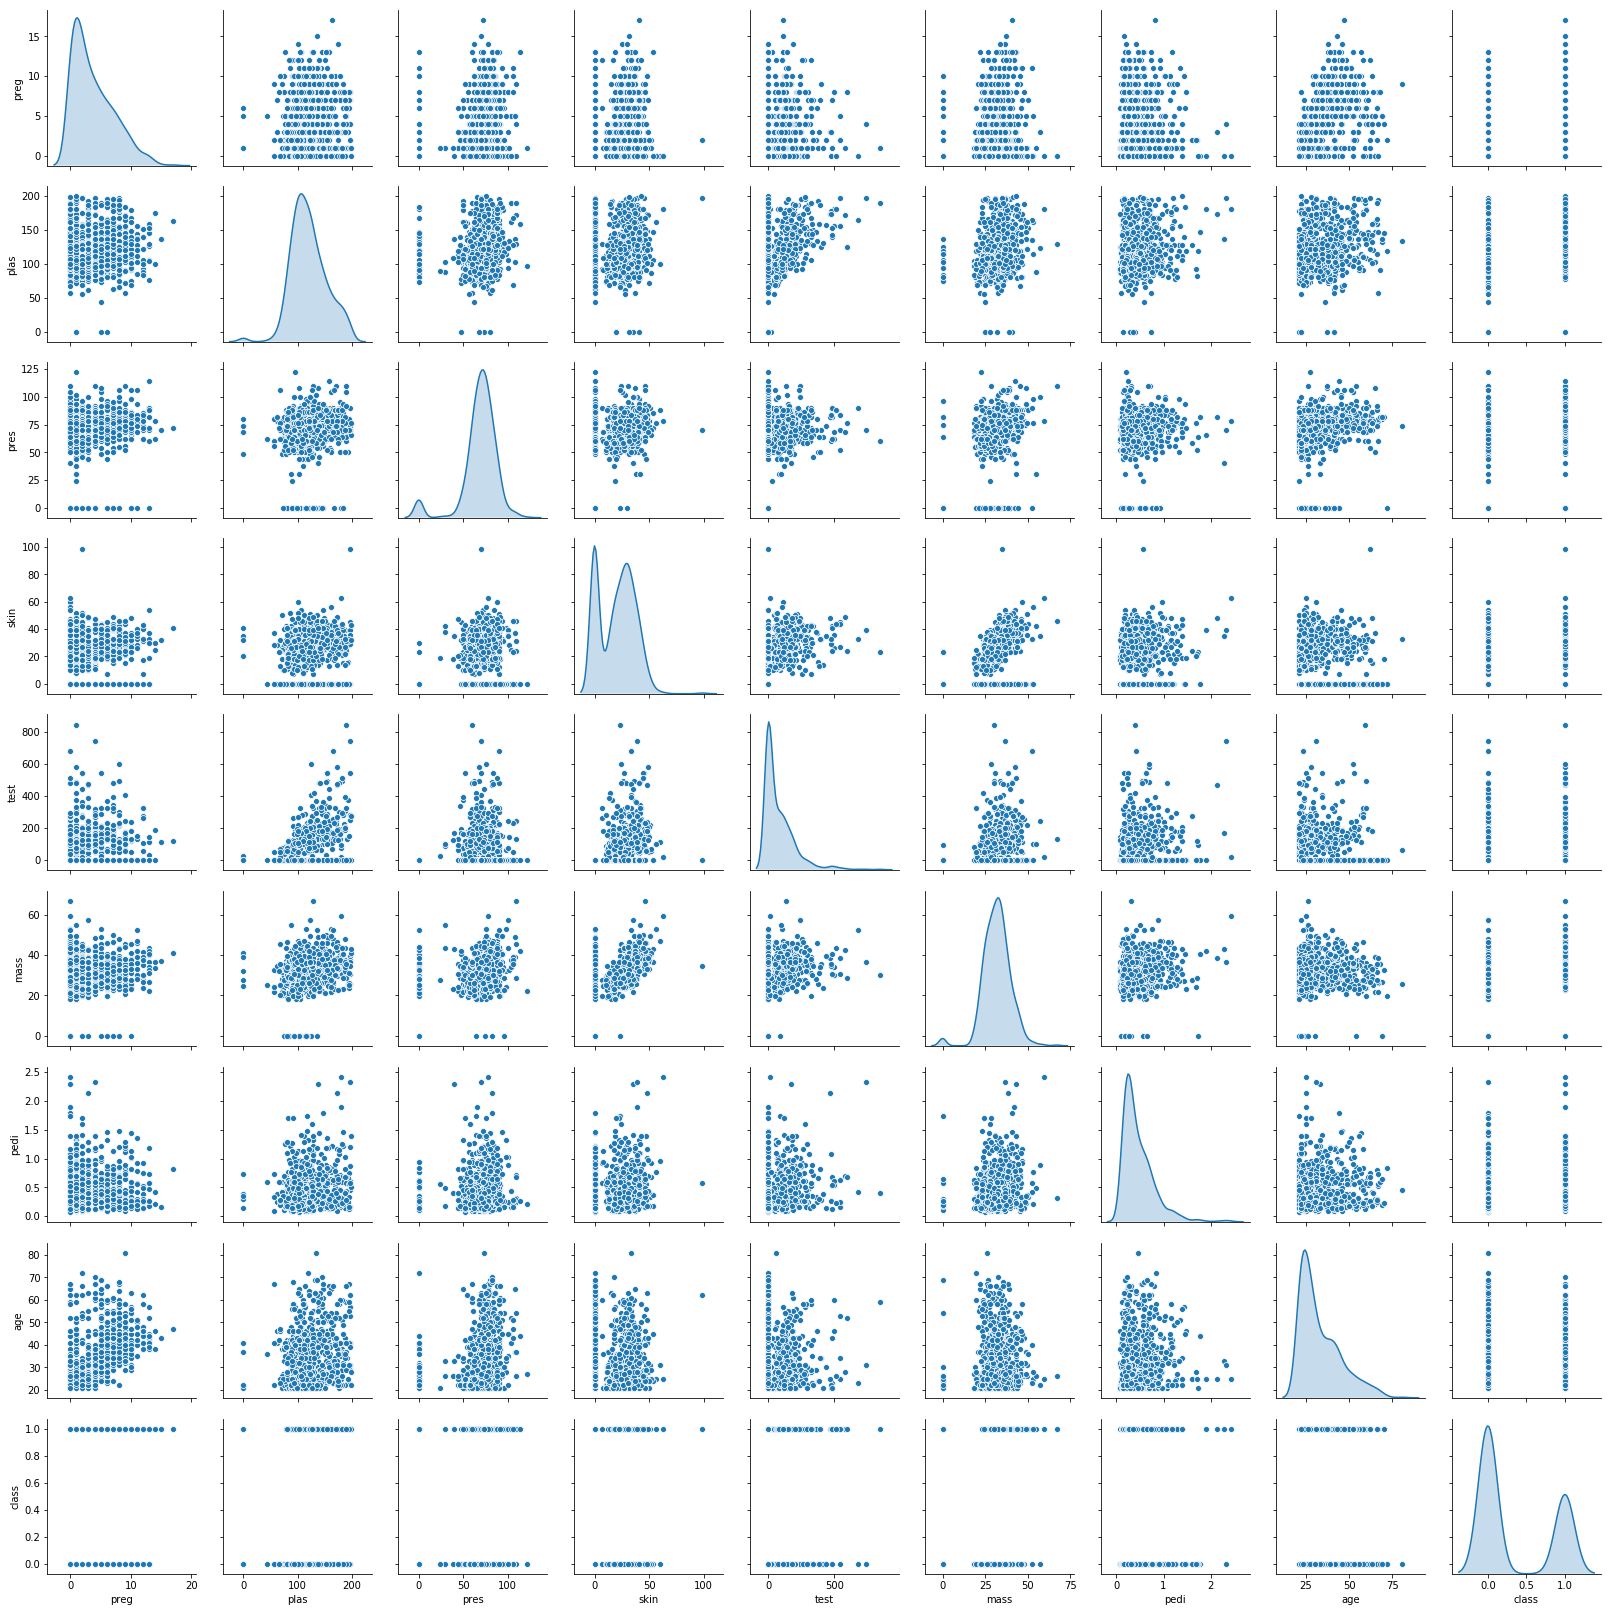

In [25]:
#::GMG::Seaborn's pairplot
# https://seaborn.pydata.org/examples/scatterplot_matrix.html
sns.pairplot(data = pima, diag_kind= 'kde')

class
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

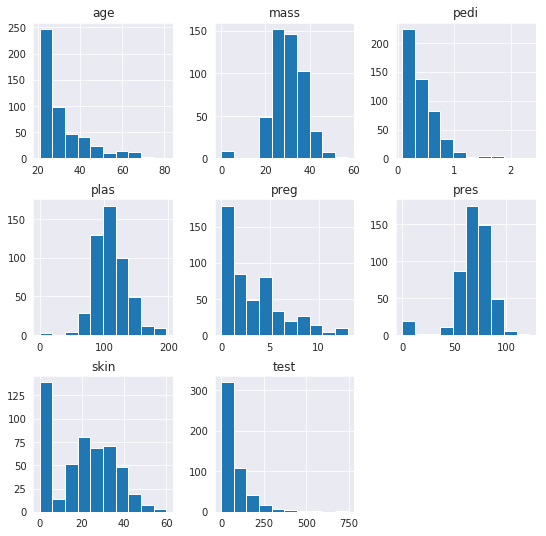

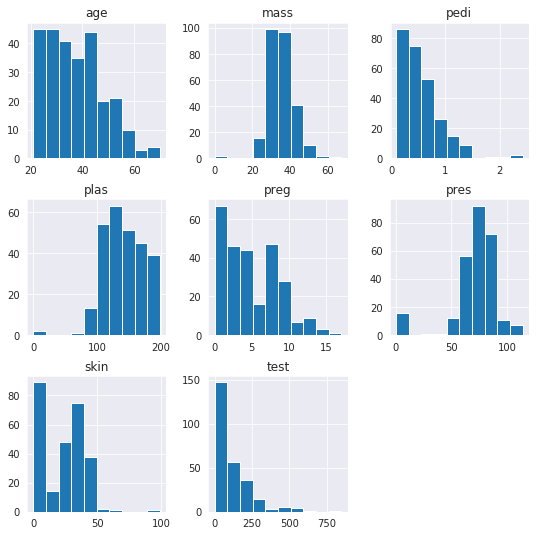

In [32]:
#::GMG::Histograms of the features grouped by Outcome
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
pima.groupby('class').hist(figsize=(9, 9))

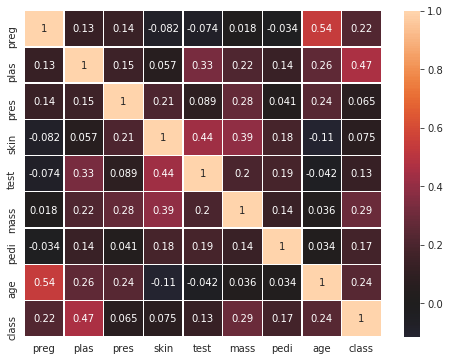

In [28]:
#::GMG::Not much insight from seaborn correlation plot
color = sns.color_palette()
sns.set_style('darkgrid')
plt.subplots(figsize=(8,6))
sns.heatmap(data = pima.corr(), center = 0, annot = True, linewidths =.3)

In [29]:
#::GMG::Beware of the imbalance dataset ...
#       https://www.quora.com/What-is-an-imbalanced-dataset
#       https://www.datacamp.com/community/tutorials/diving-deep-imbalanced-data
#       https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
#       How do I check?
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
pima.groupby('class').size()

class
0    500
1    268
dtype: int64

Text(0, 0.5, 'Frequency %')

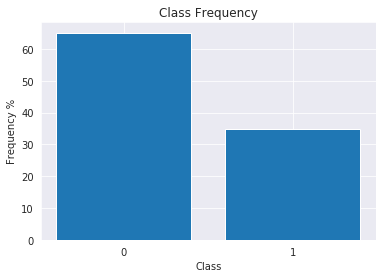

In [31]:
#::GMG::Say, 0 healthy, 1 diabetes
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.chararray.astype.html
# https://matplotlib.org/gallery/lines_bars_and_markers/categorical_variables.html
classes = pima['class'].values
unique, counts = np.unique(classes, return_counts=True)
plt.bar(unique.astype(np.character),100*counts/classes.size)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency %')

In [38]:
#::GMG::Outliers
#       plas, press, skin, test, mass 
#       which have zeros (min) in their values
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
print("Zero Plasma Glucose  Total: ", pima[pima.plas == 0].shape[0])
print("Zero Blood Pressure  Total: ", pima[pima.pres == 0].shape[0])
print("Zero Skin Thickness  Total: ", pima[(pima.skin == 0)].shape[0])
print("Zero Insulin level   Total: ", pima[pima.test == 0].shape[0])
print("Zero Body Mass Index Total: ", pima[pima.mass == 0].shape[0])

Zero Plasma Glucose  Total:  5
Zero Blood Pressure  Total:  35
Zero Skin Thickness  Total:  227
Zero Insulin level   Total:  374
Zero Body Mass Index Total:  11


In [39]:
#::GMG::How do ouliers split between class
#::NOTE::I'm interested specifically in the most common
print("Zero Skin Thickness  Total (pos): ", pima[(pima.skin == 0) & (pima['class'] == 0)].shape[0])
print("Zero Skin Thickness  Total (neg): ", pima[(pima.skin == 0) & (pima['class'] == 1)].shape[0])
print("Zero Insulin level   Total (pos): ", pima[(pima.test == 0) & (pima['class'] == 0)].shape[0])
print("Zero Insulin level   Total (neg): ", pima[(pima.test == 0) & (pima['class'] == 1)].shape[0])

Zero Skin Thickness  Total (pos):  139
Zero Skin Thickness  Total (neg):  88
Zero Insulin level   Total (pos):  236
Zero Insulin level   Total (neg):  138


## Pipeline

**::GMG::** So I have an imbalanced dataset with outliers and I want to perform a feature selection and classification. For imbalance, I can use Stratified K-Fold and cross-validated (multiple) metric estimation (precision, recall, p/r curve, AUC p/r). I did it before, but *without* a pipeline. I can also remove/impute outliers for pre-processing. Here I am in doubt. Where do that pre-processing fit? Whithin de pipeline?

**::NOTE::** I'll try to clarify this. In the meantime I'll leave the dataset dirty and proceed with the pipeline :)

### split features and target

In [40]:
#::GMG::Jason uses numpy to store the dataset, split into fearures and target/predictor,
#       instead of the pandas dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html
#::NOTE::There's a warning in the pandas documentation in 0.25 version
#        Warning: We recommend using DataFrame.to_numpy() instead. 
#        BUT The platform I'm using at the moment of writing is pandas 0.23.4
# https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.values.html
X = pima.values[:,0:pima.shape[1] - 1]
y = pima.values[:,pima.shape[1] - 1]

In [41]:
X.shape

(768, 8)

In [42]:
y.shape

(768,)

### feature extraction and selection phase

In [45]:
#::GMG::create feature union
#::NOTE::I've added random_state and whiten to PCA :)
# https://mccormickml.com/2014/06/03/deep-learning-tutorial-pca-and-whitening/
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
#::NOTE:: Whitening will remove some information from the transformed signal 
#         (the relative variance scales of the components) but can sometime improve the 
#         predictive accuracy of the downstream estimators by making their data respect 
#         some hard-wired assumptions.
#
#::NOTE::By default SelectKBest uses f_classif ... it may be changed with score_func (?)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
features = []
features.append(('pca', PCA(n_components=3, random_state = 1, whiten = True)))
features.append(('select_best', SelectKBest(k = 6)))
feature_union = FeatureUnion(features)

In [46]:
feature_union

FeatureUnion(n_jobs=None,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=1,
  svd_solver='auto', tol=0.0, whiten=True)), ('select_best', SelectKBest(k=6, score_func=<function f_classif at 0x7f9c674e9d08>))],
       transformer_weights=None)

### pipeline

In [63]:
#::GMG::create pipeline = feaature selection + classification
#::NOTE::Here is where the magic do its wonders :)
#        Somehow the pipeline guarantees no data leakage given the workflow stated
#        i.e feature extraction and selection (combination at that) + classification
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', 
                   LogisticRegression(solver = 'liblinear', random_state = 1)
                  )
                 )
model = Pipeline(estimators)

In [64]:
estimators

[('feature_union', FeatureUnion(n_jobs=None,
         transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=1,
    svd_solver='auto', tol=0.0, whiten=True)), ('select_best', SelectKBest(k=6, score_func=<function f_classif at 0x7f9c674e9d08>))],
         transformer_weights=None)),
 ('logistic',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
            tol=0.0001, verbose=0, warm_start=False))]

In [49]:
model

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=1,
  svd_solver='auto', tol=0.0, whiten=True)), ('select_best', SelectKBest(k=6, score_func=<function f_classif at 0x7f9c674e9d08>))],
       transfo...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

### (multiple score) cv evaluation

In [52]:
#::GMG::pipeline (experiment) evaluation
#::NOTE::Seed for replication (kfold)
seed = 7

In [53]:
#::GMG::Scores to use (mind the imbalance)
scoring = ['balanced_accuracy',
           'precision_weighted', 
           'recall_weighted',
           'f1_weighted']

In [54]:
#::GMG::I've changed KFold to StartifiedKFold to account for the imbalance and
# kfold = KFold(n_splits = 10, random_state=seed)
kfold = StratifiedKFold(n_splits = 10, random_state = seed)

In [65]:
#::GMG::Do the magic :)
# Fisrt I do it wuth ONE metric, to be sure
results = cross_val_score(estimator= model, 
                          X = X, 
                          y = y, 
                          cv = kfold, 
                          scoring = 'balanced_accuracy'
                         )

In [72]:
print('Balanced Accuracy: {:4.3} (\u00B1 {:4.3})'.format(results.mean(), 2 *results.std()))

Balanced Accuracy: 0.725 (± 0.0711)


In [75]:
#::GMG::But it also may be done with multiple scores ... 
#
m_results = cross_validate(estimator = model, 
                           X = X, 
                           y = y, 
                           cv = kfold, 
                           scoring = scoring,
                           return_train_score= False
                          )

In [77]:
print(
    'Balanced Accuracy: {:4.3} (\u00B1 {:4.3})\n precision: {:4.3} (\u00B1 {:4.3})\n recall: {:4.3} (\u00B1 {:4.3})\n f_1: {:4.3} (\u00B1 {:4.3})'
      .format(
              m_results['test_balanced_accuracy'].mean(), 2 *m_results['test_balanced_accuracy'].std(),
              m_results['test_precision_weighted'].mean(), 2 *m_results['test_precision_weighted'].std(),
              m_results['test_recall_weighted'].mean(), 2 *m_results['test_recall_weighted'].std(),
              m_results['test_f1_weighted'].mean(), 2 *m_results['test_f1_weighted'].std()
      )
) 

Balanced Accuracy: 0.725 (± 0.0711)
 precision: 0.772 (± 0.0776)
 recall: 0.773 (± 0.0743)
 f_1: 0.765 (± 0.0731)


## Notes

**::GMG::** In Brownlee (2014) post responses there is [an interesting thread](https://machinelearningmastery.com/an-introduction-to-feature-selection/#comment-484560) where `Sara` describes a wrapper `RFECV` + `GridSearchCV` but without a pipeline ... kind of what I'd like to do. Jason told her:

> Hmmm, too much CV going on I think, unless you have a ton of data.
>
>A good pipeline might be [[data prep] + [algorithm]] and grid search CV is applied to the whole lot.

Then she [tries to do it in a pipeline](https://machinelearningmastery.com/an-introduction-to-feature-selection/#comment-484643) but without success. And Jason wasn't abel to help her debug it.  here is the code snippet:

```python
pipeline1 = Pipeline(
    [ (‘feature_selection’,SelectFromModel(svm.SVC(kernel=’linear’))),
      (‘filter’ , SelectKBest(k=11)),
      (‘classification’ , svm.SVC(kernel=’linear’))
    ]
)

gridparams = [{‘C’: [0.01, 0.1, 1, 10, 100, 1000]}]

model = GridSearchCV(pipeline1, gridparams, cv=5)

model.fit(X, y)
```

An here is the error she gets:

```python
ValueError: Invalid parameter estimator for estimator Pipeline(memory=None,
steps=[(‘feature_union’, FeatureUnion(n_jobs=None,
transformer_list=[(‘filter’, SelectKBest(k=’all’, score_func=)), (‘feature_selection’, SelectFromModel(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape=’ovr…r’, max_iter=-1, probability=False, random_state=None,
shrinking=True, tol=0.001, verbose=False))]). Check the list of available parameters with estimator.get_params().keys().
```

**::GMG::** I've used the following references:

  - [Scikit-learn](https://scikit-learn.org/stable/modules/svm.html) 1.4. Support Vector Machines
  - [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) `sklearn.svm.SVC`
  - [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) `sklearn.feature_selection.SelectFromModel`
  - [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) `sklearn.model_selection.GridSearchCV`

In [87]:
#::GMG::See Notes
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [94]:
#::GMG::I'll give a try
#::NOTE::I use feature union for the feature extraction/selection phase
features_sara = []
features_sara.append(('wrapper', 
                      SelectFromModel(
                          estimator = SVC(kernel = 'linear', random_state = 1)
                      )
                     )
                    )
#::NOTE::SelctKbest default is f_classif                      
features_sara.append(
    ('filter', SelectKBest(k = 6))
)
feature_union_sara = FeatureUnion(features_sara)

In [95]:
feature_union_sara

FeatureUnion(n_jobs=None,
       transformer_list=[('wrapper', SelectFromModel(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)), ('filter', SelectKBest(k=6, score_func=<function f_classif at 0x7f9c674e9d08>))],
       transformer_weights=None)

In [96]:
#::GMG::I build carefully the estimators
estimators_sara = []
estimators_sara.append(
    ('feature_union', feature_union_sara)
)
estimators_sara.append(
    ('classification', SVC(kernel = 'linear', class_weight = 'balanced', gamma= 'scale', random_state = 2))
)

In [97]:
estimators_sara

[('feature_union', FeatureUnion(n_jobs=None,
         transformer_list=[('wrapper', SelectFromModel(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=1,
    shrinking=True, tol=0.001, verbose=False),
          max_features=None, norm_order=1, prefit=False, threshold=None)), ('filter', SelectKBest(k=6, score_func=<function f_classif at 0x7f9c674e9d08>))],
         transformer_weights=None)),
 ('classification',
  SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=2, shrinking=True,
    tol=0.001, verbose=False))]

In [98]:
#::GMG::Now the pipeline
pipeline_sara = Pipeline(estimators_sara)

In [99]:
pipeline_sara

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('wrapper', SelectFromModel(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_sta...ar',
  max_iter=-1, probability=False, random_state=2, shrinking=True,
  tol=0.001, verbose=False))])

In [100]:
gridparams_sara = {'classification__C': [0.01, 0.1, 1, 10, 100, 1000]}

In [101]:
model_sara = GridSearchCV(estimator = pipeline_sara, 
                          param_grid = gridparams_sara, 
                          cv = 5, 
                          scoring = 'balanced_accuracy',
                          refit = True,
                          return_train_score = False,
                          iid = False
)

In [102]:
model_sara

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('wrapper', SelectFromModel(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_sta...ar',
  max_iter=-1, probability=False, random_state=2, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'classification__C': [0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='balanced_accuracy', verbose=0)

In [ ]:
#::GMG::And .. I get the SAME error :))
model_sara.fit(X, y)

**::GMG::** My error:

```Python
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-92-af1875d7ed6c> in <module>
----> 1 model_sara.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self, X, y, groups, **fit_params)
    720                 return results_container[0]
    721 
--> 722             self._run_search(evaluate_candidates)
    723 
    724         results = results_container[0]

[...]


ValueError: Invalid parameter C for estimator Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('wrapper', SelectFromModel(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_sta...nalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.
```

In [91]:
#::GMG::Just out of curiosity from Sara's reported error ...
pipeline_sara.get_params().keys()

dict_keys(['memory', 'steps', 'feature_union', 'classification', 'feature_union__n_jobs', 'feature_union__transformer_list', 'feature_union__transformer_weights', 'feature_union__wrapper', 'feature_union__filter', 'feature_union__wrapper__estimator__C', 'feature_union__wrapper__estimator__cache_size', 'feature_union__wrapper__estimator__class_weight', 'feature_union__wrapper__estimator__coef0', 'feature_union__wrapper__estimator__decision_function_shape', 'feature_union__wrapper__estimator__degree', 'feature_union__wrapper__estimator__gamma', 'feature_union__wrapper__estimator__kernel', 'feature_union__wrapper__estimator__max_iter', 'feature_union__wrapper__estimator__probability', 'feature_union__wrapper__estimator__random_state', 'feature_union__wrapper__estimator__shrinking', 'feature_union__wrapper__estimator__tol', 'feature_union__wrapper__estimator__verbose', 'feature_union__wrapper__estimator', 'feature_union__wrapper__max_features', 'feature_union__wrapper__norm_order', 'featur

**::FIX::** The problem is which C is the `gridparams_sara` defining. If you do `pipeline_sara.get_params().keys()` you will see there are **two** Cs, i.e `feature_union__wrapper__estimator__C` and `classification__C`. You must choose one with its *full name*. That's it.